# seismic amplitude extraction

Inspired by a strong hate towards [_your favourite interpretation platform_], here's how to do basic amplitude extraction in Python.

Similarly to what I did for my [Seismic Petrophysics notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb), I will use data available from the [Quantitative Seismic Interpretation book website](https://srb.stanford.edu/quantitative-seismic-interpretation).


<!-- In the future, I would like to add a comparison in terms of results and computation times with extractions done in OpenDTect and Petrel and also show how to display amplitude maps in true geographical coordinates (but to do that I first need to find an open source dataset with all the information needed, i.e., latitude and longitude etc). -->

## data loading & preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bruges
from obspy.io.segy.segy import _read_segy

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

To load a 3D cube in SEG-Y format (see also [my other notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_data_in_python.ipynb)):

In [6]:
filename='3d_nearstack.sgy'

segy = _read_segy(filename,unpack_headers=True)
nt   = len(segy.traces)
ns   = segy.binary_file_header.number_of_samples_per_data_trace
sr   = segy.binary_file_header.sample_interval_in_microseconds/1000 # converts sample rate to milliseconds

seis = np.zeros((nsamples,ntraces))
for i, trace in enumerate(segy.traces):
    seis[:,i] = trace.data

I have the following information:

* inline: 1300-1500, every 2
* xline: 1500-2000, every 2
* time: 1500-2500 ms
* total 25351 traces for each subcube.

I can now reshape the seismic dataset into a 3D Numpy array to make it easy to access to individual lines or timeslices:

In [7]:
inl=np.arange(1300,1502,2)
crl=np.arange(1500,2002,2)

seis=seis.reshape(nsamples,inl.size,crl.size)

The first dimension is time, then inlines and crosslines:

* 250 twt samples x 101 inlines x 251 crosslines


I will build now a two-way-time scale by reading the position of the first sample (lagtime) and the sample rate:

In [12]:
lagtime = 1500
twt = np.arange(lagtime,lagtime+ns*sr,sr)

In [14]:
print('First sample: {0} ms, last sample: {1} ms'.format(twt.min(), twt.max()))

First sample: 1500.0 ms, last sample: 2496.0 ms


Now I will load an interpreted horizon:

In [15]:
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])

## display seismic and interpretation

To display an inline with interpretation on top:

(<matplotlib.text.Text at 0x119bc04e0>, <matplotlib.text.Text at 0x11990bdd8>)

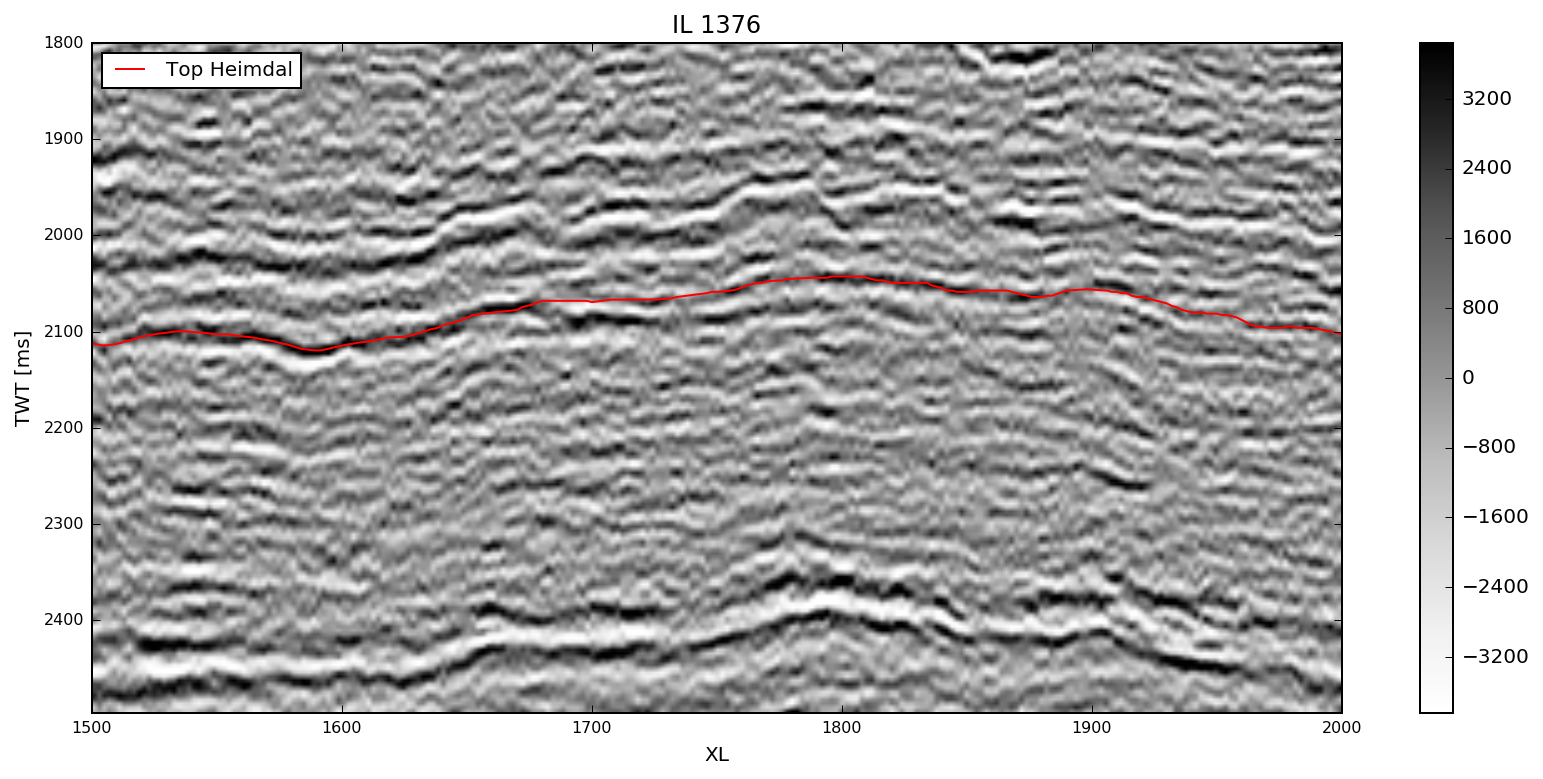

In [16]:
inline=1376
ii_idx=inl.tolist().index(inline)
clip=abs(np.percentile(seis, 0.80))

plt.figure(figsize=(14,6))
plt.imshow(seis[:,ii_idx,:],extent=[crl.min(),crl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
plt.plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',label='Top Heimdal')
plt.legend(loc='upper left', fontsize=10)
plt.colorbar(),
plt.xlim(crl.min(),crl.max())
plt.ylim(twt.max(),1800)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('IL {0}'.format(inline))
plt.ylabel('TWT [ms]'), plt.xlabel('XL')

### fancy interlude: interactive viewer for 3D data

A fancier display showing one inline, one crossline and a timeslice of your choice (uses the interactive widgets of IPython/Jupyter notebooks so it only works when the notebook is run locally):

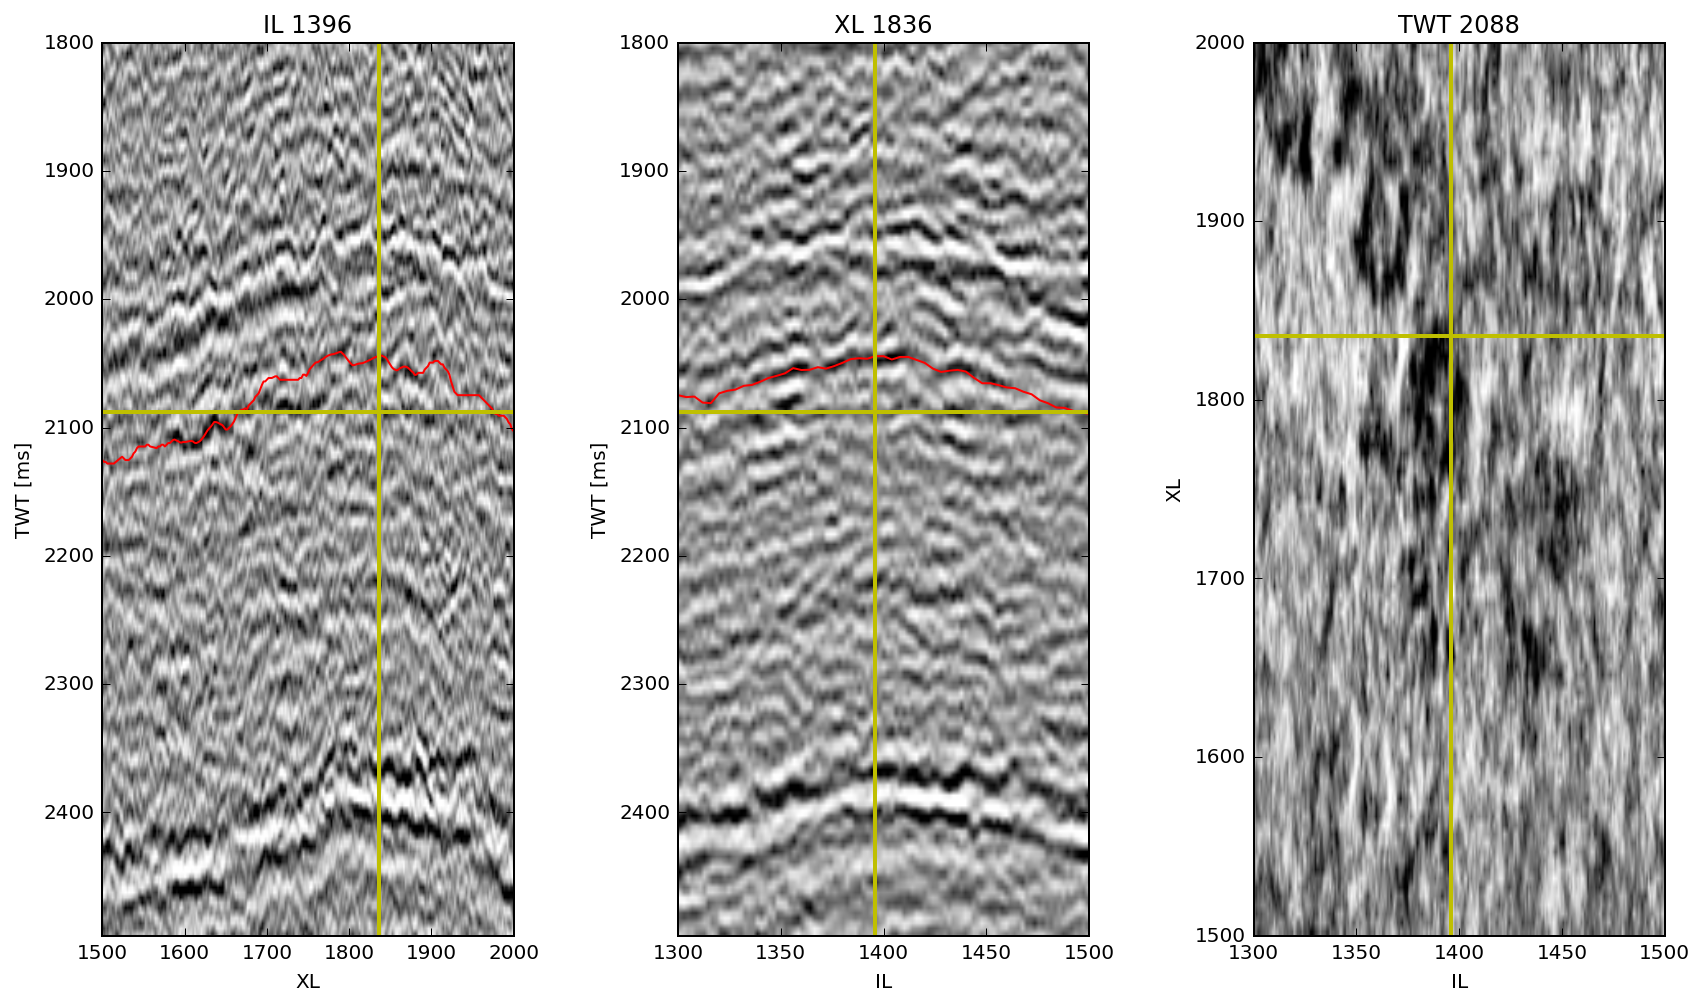

In [17]:
from ipywidgets import interact
    
@interact(ii=(1300,1500,24),cc=(1500,2000,48),zz=(1800,2496,48))
def seisview3d(ii=1372,cc=1788,zz=2136):
    clip=abs(np.percentile(seis, 0.80))   

    ii_idx=inl.tolist().index(ii)
    cc_idx=crl.tolist().index(cc)
    zz_idx=twt.tolist().index(zz)
    
    f, ax = plt.subplots(1,3, figsize=(14,8))

    ax[0].imshow(seis[:,ii_idx,:],extent=[crl.min(),crl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[0].plot(hrz[hrz['il']==ii]['xl'],hrz[hrz['il']==ii]['z'],color='r') 
    ax[0].axhline(zz,color='y',lw=2)
    ax[0].axvline(cc,color='y',lw=2)   
    ax[0].set_ylim(twt.max(),1800)
    ax[0].set_title('IL {0}'.format(ii))
    ax[0].set_xlabel('XL'), ax[0].set_ylabel('TWT [ms]')

    ax[1].imshow(seis[:,:,cc_idx],extent=[inl.min(),inl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[1].plot(hrz[hrz['xl']==cc]['il'],hrz[hrz['xl']==cc]['z'],color='r')
    ax[1].axhline(zz,color='y',lw=2)
    ax[1].axvline(ii,color='y',lw=2)
    ax[1].set_ylim(twt.max(),1800)
    ax[1].set_title('XL {0}'.format(cc))
    ax[1].set_xlabel('IL'), ax[1].set_ylabel('TWT [ms]')

    ax[2].imshow(seis[zz_idx,:,:],extent=[inl.min(),inl.max(),crl.min(),crl.max()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[2].axhline(cc,color='y',lw=2)
    ax[2].axvline(ii,color='y',lw=2)
    ax[2].set_title('TWT {0}'.format(zz))
    ax[2].set_xlabel('IL'), ax[2].set_ylabel('XL')
    f.subplots_adjust(wspace=.4)

## extracting amplitudes, the basics

Amplitudes along an horizon can be extracted in 3 ways:

* get the amplitude value from sample closer to actual pick (fastest)
* interpolate with `scipy.interpolate.interp1d` (slow)
* interpolate with `scipy.interpolate.splrep` / `splev` (unexpectedly fast)

As an exercise I will compare these three methods and show the elapsed time to do the extraction for a single inline:

In [20]:
import time
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep

hrz_sub=hrz[hrz['il']==1376]
twt_finer=np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale

amp0=np.zeros((hrz_sub.size,2))
start = time.time()
for i in range(hrz_sub.size):
    ii_idx=inl.tolist().index(hrz_sub['il'][i])
    cc_idx=crl.tolist().index(hrz_sub['xl'][i])  
    zz_idx = np.abs(twt-hrz_sub['z'][i]).argmin()
    amp0[i,0] = hrz_sub['xl'][i]
    amp0[i,1] = seis[zz_idx, ii_idx, cc_idx]
end = time.time()
elapsed_raw = end - start

amp1=np.zeros((hrz_sub.size,2))
start = time.time()
for i in range(hrz_sub.size):
    ii_idx=inl.tolist().index(hrz_sub['il'][i])
    cc_idx=crl.tolist().index(hrz_sub['xl'][i])  
    trace = seis[:, ii_idx, cc_idx].flatten()
    ff = interp1d(twt, trace, kind='cubic')
    amp1[i,0] = hrz_sub['xl'][i]
    amp1[i,1] = ff(hrz_sub['z'][i])
end = time.time()
elapsed_interp1d = end - start

amp2=np.zeros((hrz_sub.size,2))
start = time.time()
for i in range(hrz_sub.size):
    ii_idx=inl.tolist().index(hrz_sub['il'][i])
    cc_idx=crl.tolist().index(hrz_sub['xl'][i])  
    trace = seis[:, ii_idx, cc_idx].flatten()
    ff = splrep(twt, trace)
    amp2[i,0] = hrz_sub['xl'][i]
    amp2[i,1] = splev(hrz_sub['z'][i], ff)
end = time.time()
elapsed_splev = end - start

print('Time to extract amplitudes at closest sample: {:.2f} seconds.'.format(elapsed_raw))
print('Time to extract amplitudes by interpolation with interp1d: {:.2f} seconds.'.format(elapsed_interp1d))
print('Time to extract amplitudes by interpolation with splrep/splev: {:.2f} seconds.'.format(elapsed_splev))

diff = amp1[:,1] - amp2[:,1]
print('Average difference between interp1d and splrep/splev: {0}'.format(np.mean(diff)))

Time to extract amplitudes at closest sample: 0.02 seconds.
Time to extract amplitudes by interpolation with interp1d: 6.86 seconds.
Time to extract amplitudes by interpolation with splrep/splev: 0.06 seconds.
Average difference between interp1d and splrep/splev: -4.2968727292504465e-13


The last output above also confirms that `interp1d` and `splrep / splev` deliver the same results; as it is much slower, I will therefore drop the use of `interp1d` from now on.

Now, a graphical comparison between raw vs interpolated amplitudes:

(1600, 1900)

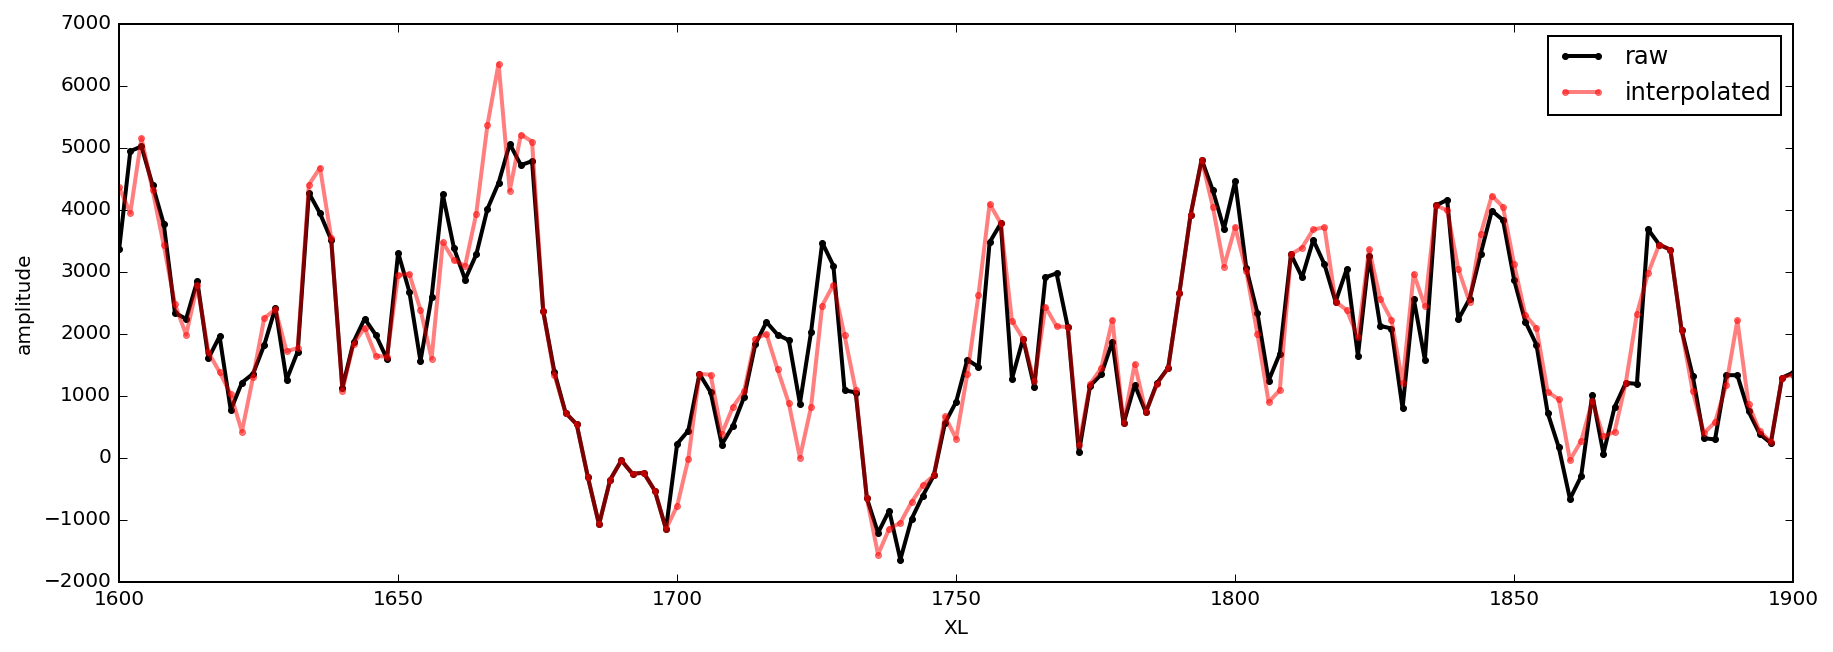

In [21]:
plt.figure(figsize=(15,5))
plt.plot(amp0[:,0], amp0[:,1], '.-k', lw=2, label='raw')
plt.plot(amp2[:,0], amp2[:,1], '.-r', lw=2, alpha=0.5, label='interpolated')
plt.legend()
plt.xlabel('XL')
plt.ylabel('amplitude')
plt.xlim(1600,1900)

## amplitude extraction on 3D data

I will now extend the method above to cover the entire 3D dataset.

First I create an array to contain all the background information (geometry and interpretion) and the results of the extraction; this array `hrz_extr` will have 6 columns and as many rows as the original interpretation:
 
* column 0 = inline
* column 1 = crossline
* column 2 = picked two-way-time picks
* column 3 = amplitude of closest sample
* column 4 = amplitude interpolated at actual pick time with `splev / sprep`
* column 5 = windowed RMS amplitude

In [23]:
hrz_extr = np.zeros((hrz.size,6))
twt_finer = np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale
window = 8 # 8 samples = 32 ms

start = time.time()
for i in range(hrz.size):
    ii_idx=inl.tolist().index(hrz['il'][i])
    cc_idx=crl.tolist().index(hrz['xl'][i])  
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()
    amp_raw = seis[zz_idx, ii_idx, cc_idx].flatten()
    amp_rms = np.sqrt(np.mean((np.square(seis[zz_idx-window/2:zz_idx+window/2, ii_idx, cc_idx]))))
    
    trace = seis[:, ii_idx, cc_idx].flatten()
    ff = splrep(twt, trace)
    amp_splev = splev(hrz['z'][i], ff)

    hrz_extr[i,0] = hrz['il'][i]
    hrz_extr[i,1] = hrz['xl'][i]
    hrz_extr[i,2] = hrz['z'][i]
    hrz_extr[i,3] = amp_raw
    hrz_extr[i,4] = amp_splev
    hrz_extr[i,5] = amp_rms
end = time.time()
elapsed = end - start

print('Time to extract amplitudes on 3D cube: {:.2f} seconds.'.format(elapsed))

/Users/aadm/miniconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Time to extract amplitudes on 3D cube: 2.89 seconds.


Let's grid the data and display it as 2D maps:

In [24]:
from scipy.interpolate import griddata
from scipy import ndimage

xi = np.linspace(inl.min(), inl.max(),250)
yi = np.linspace(crl.min(), crl.max(),250)
X, Y = np.meshgrid(xi, yi)
Z=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,2],(X,Y),method='cubic')
Araw=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,3],(X,Y),method='cubic')
Aspl=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,4],(X,Y),method='cubic')
Arms=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,5],(X,Y),method='cubic')

# smooth the time interpretation for a nicer contouring
Zf=ndimage.gaussian_filter(Z,sigma=3,order=0)

This first plot is useful to compare the results of using "raw" vs interpolated amplitude:

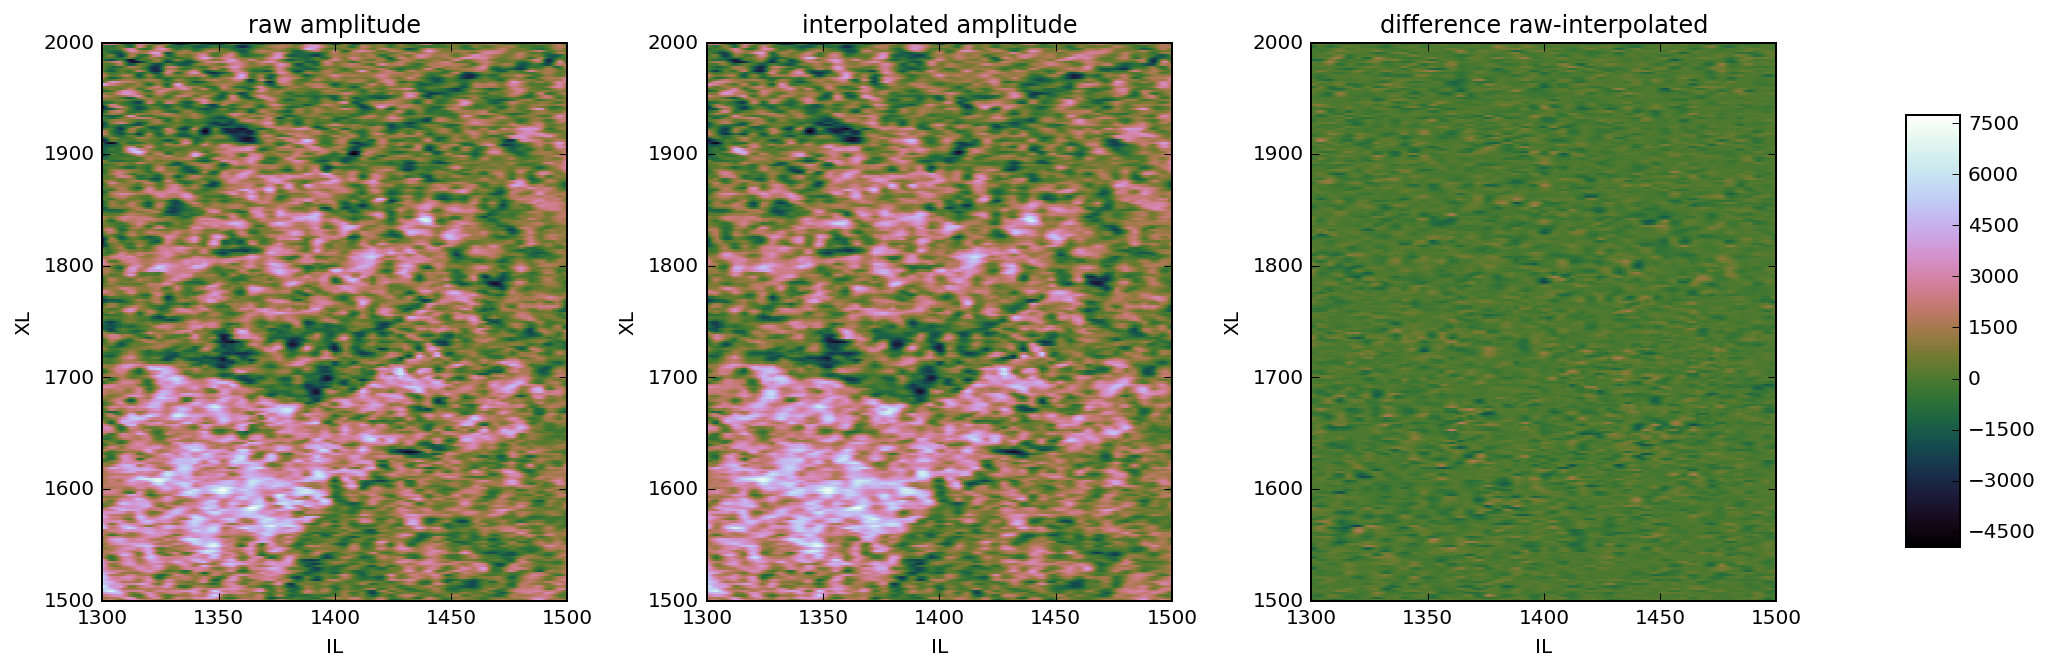

In [25]:
clip_max=np.max(hrz_extr[:,3:5])
clip_min=np.min(hrz_extr[:,3:5])

f, ax = plt.subplots(1,3,figsize=(15,5))
map0 = ax[0].pcolormesh(X, Y, Araw, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
map1 = ax[1].pcolormesh(X, Y, Aspl, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
map2 = ax[2].pcolormesh(X, Y, Araw-Aspl, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
ax[0].set_title('raw amplitude')
ax[1].set_title('interpolated amplitude')
ax[2].set_title('difference raw-interpolated')
for aa in ax.flatten():
    aa.set_xlabel('IL'), aa.set_ylabel('XL')
f.subplots_adjust(wspace=.3)
cax = f.add_axes([0.96, 0.2, 0.025, 0.6])
f.colorbar(map0, cax=cax, orientation='vertical')

The following plot shows more clearly the differences between the two types of extraction along a few inlines:

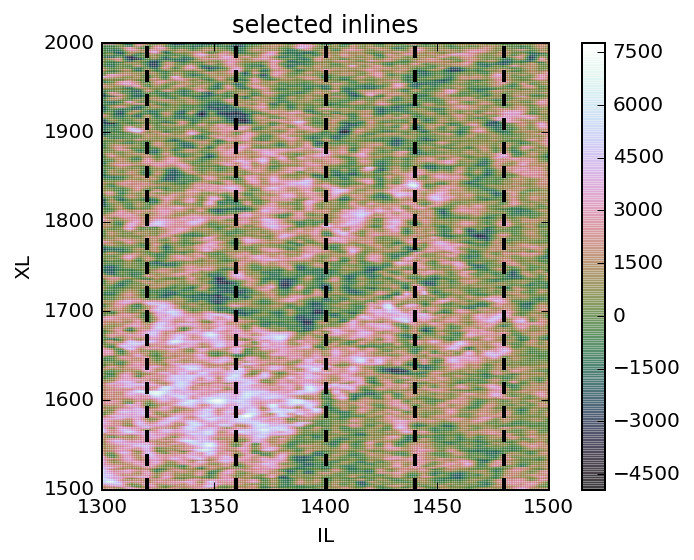

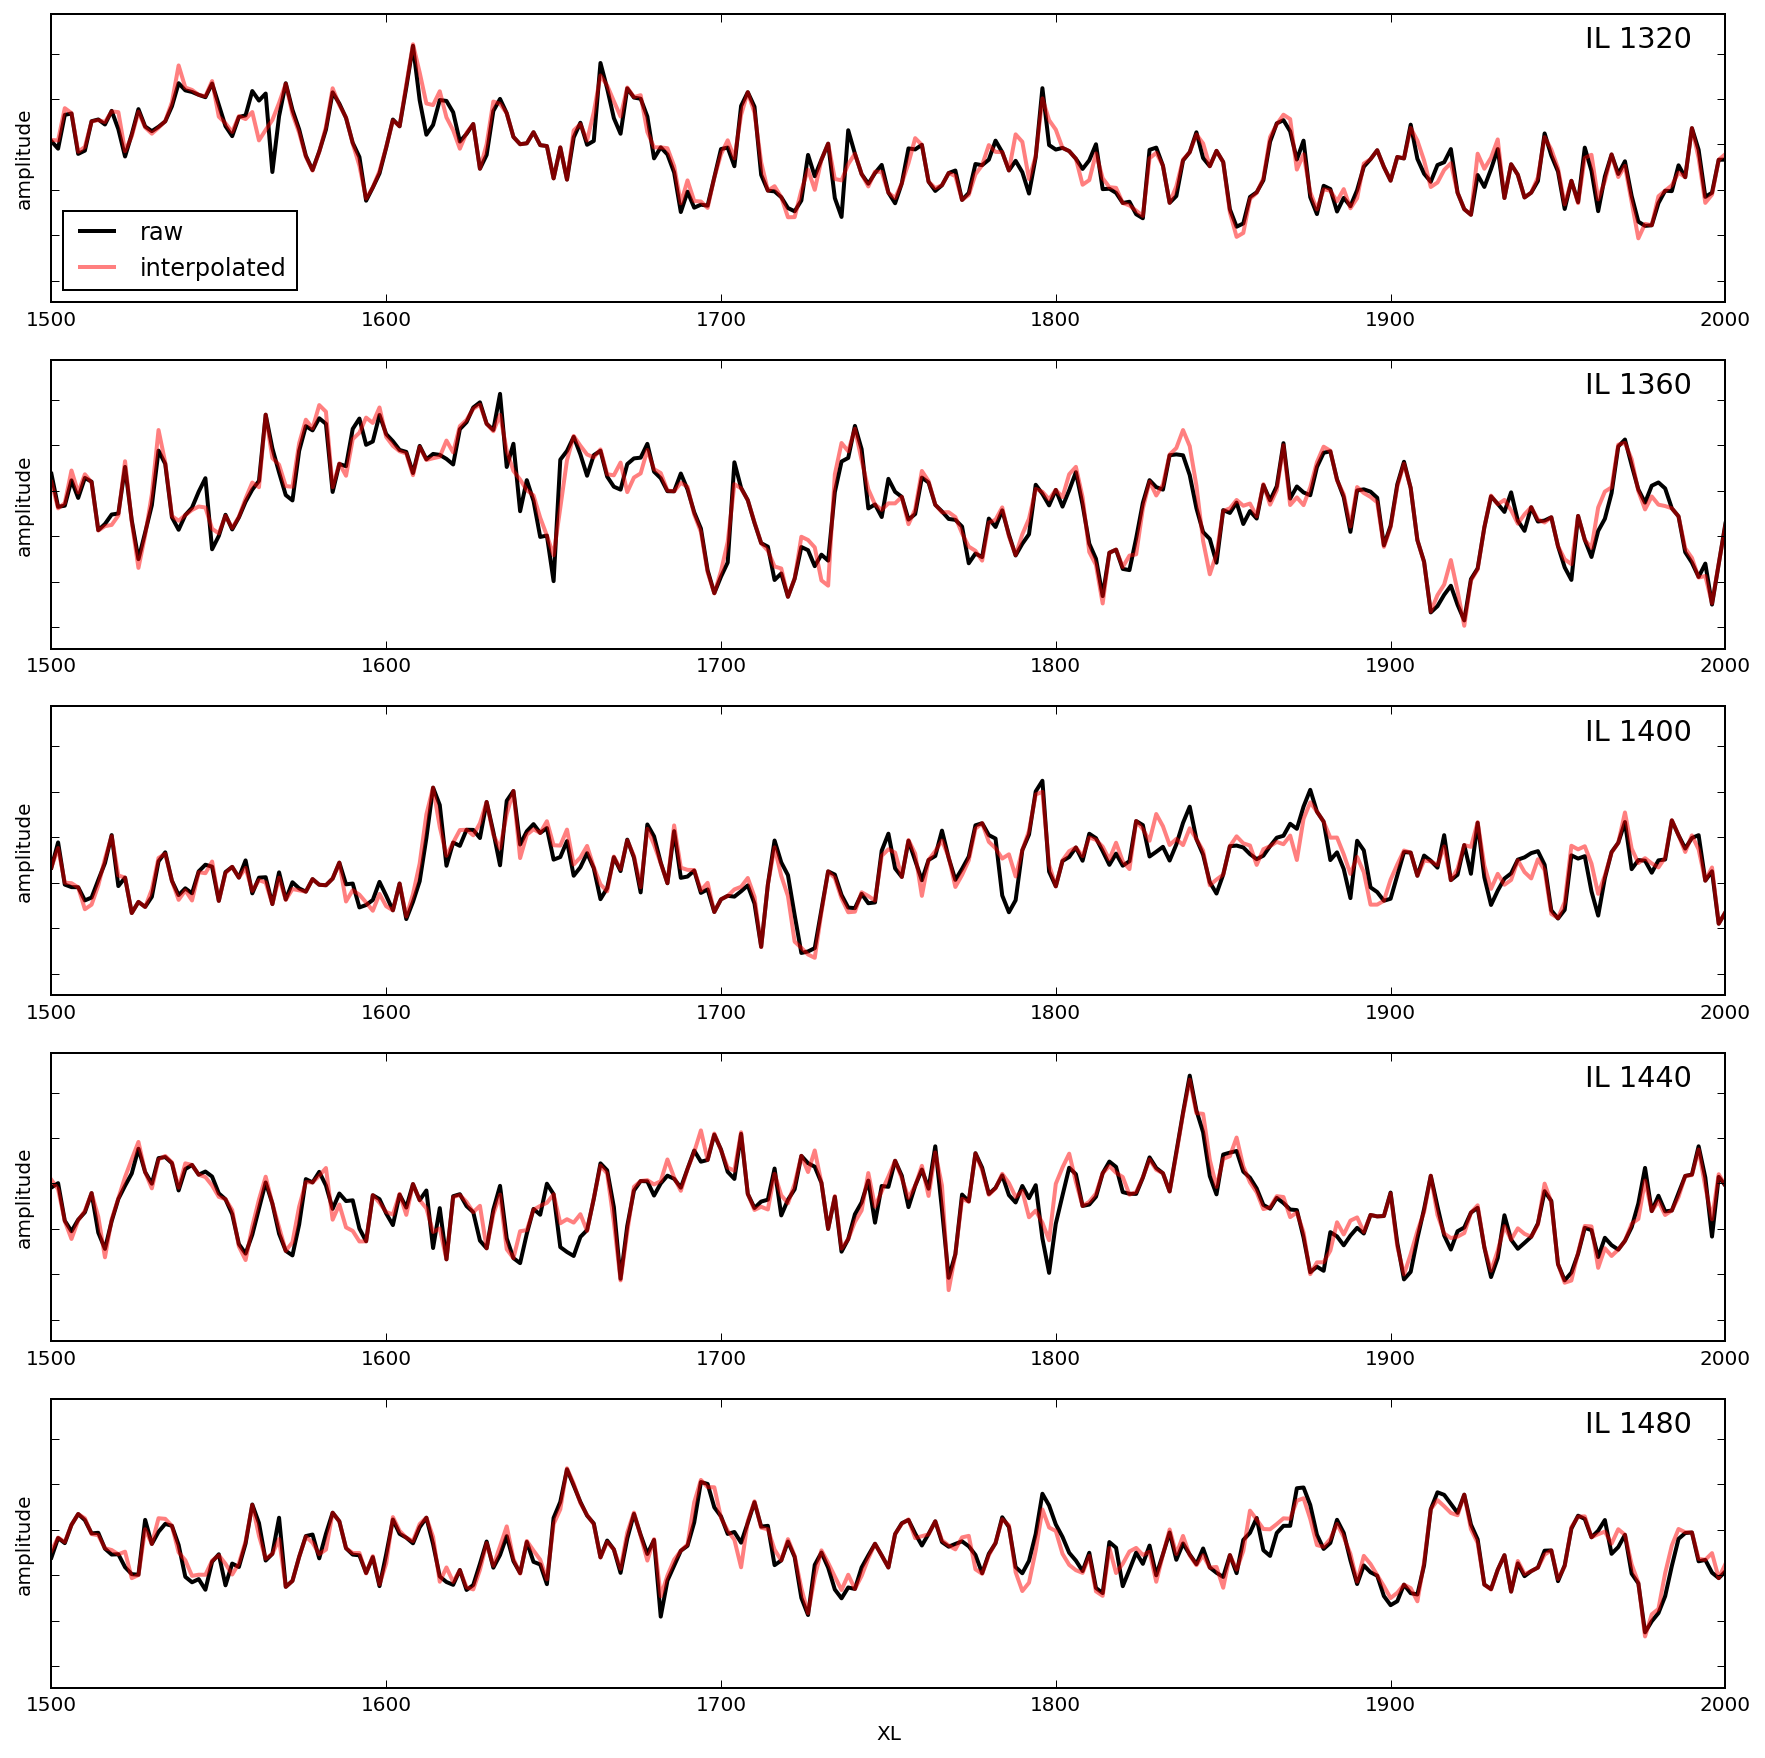

In [26]:
plt.figure()
plt.pcolormesh(X, Y, Araw, vmin=clip_min, vmax=clip_max, cmap='cubehelix', alpha=0.5)
for r,val in enumerate(inl[10::20]):
    plt.axvline(val, color='k', ls='--', lw=2)
plt.colorbar()
plt.axes().set_aspect(0.4)
plt.xlabel('IL'), plt.ylabel('XL')
plt.title('selected inlines')
    
f, ax = plt.subplots(inl[10::20].size,1,figsize=(15,15))
for r,val in enumerate(inl[10::20]):
    crosslines = hrz_extr[hrz_extr[:,0]==val][:,1]
    amp_raw    = hrz_extr[hrz_extr[:,0]==val][:,3]
    amp_splev  = hrz_extr[hrz_extr[:,0]==val][:,4]

    ax[r].plot(crosslines, amp_raw, '-k', lw=2, label='raw')
    ax[r].plot(crosslines, amp_splev, '-r', lw=2, alpha=0.5, label='interpolated')

    ax[r].set_ylim(clip_min,clip_max)
    ax[r].set_yticklabels([])
    ax[r].set_ylabel('amplitude')
    ax[r].text(0.98,0.96,'IL {0}'.format(val),size='x-large',
    ha='right',va='top',transform=ax[r].transAxes)
ax[0].legend(loc='lower left')
ax[r].set_xlabel('XL')

The conclusion (for me) is that the simplest approach is reasonably accurate, but since the time penalty of using interpolation (provided it is `splrep / splev` and not `interp1d`) is so small, then why not using it.

In this last plot I compare amplitudes extracted at the horizon with RMS values from a 32 ms window centered on the horizon; structure contours (in time) are superimposed on the maps.

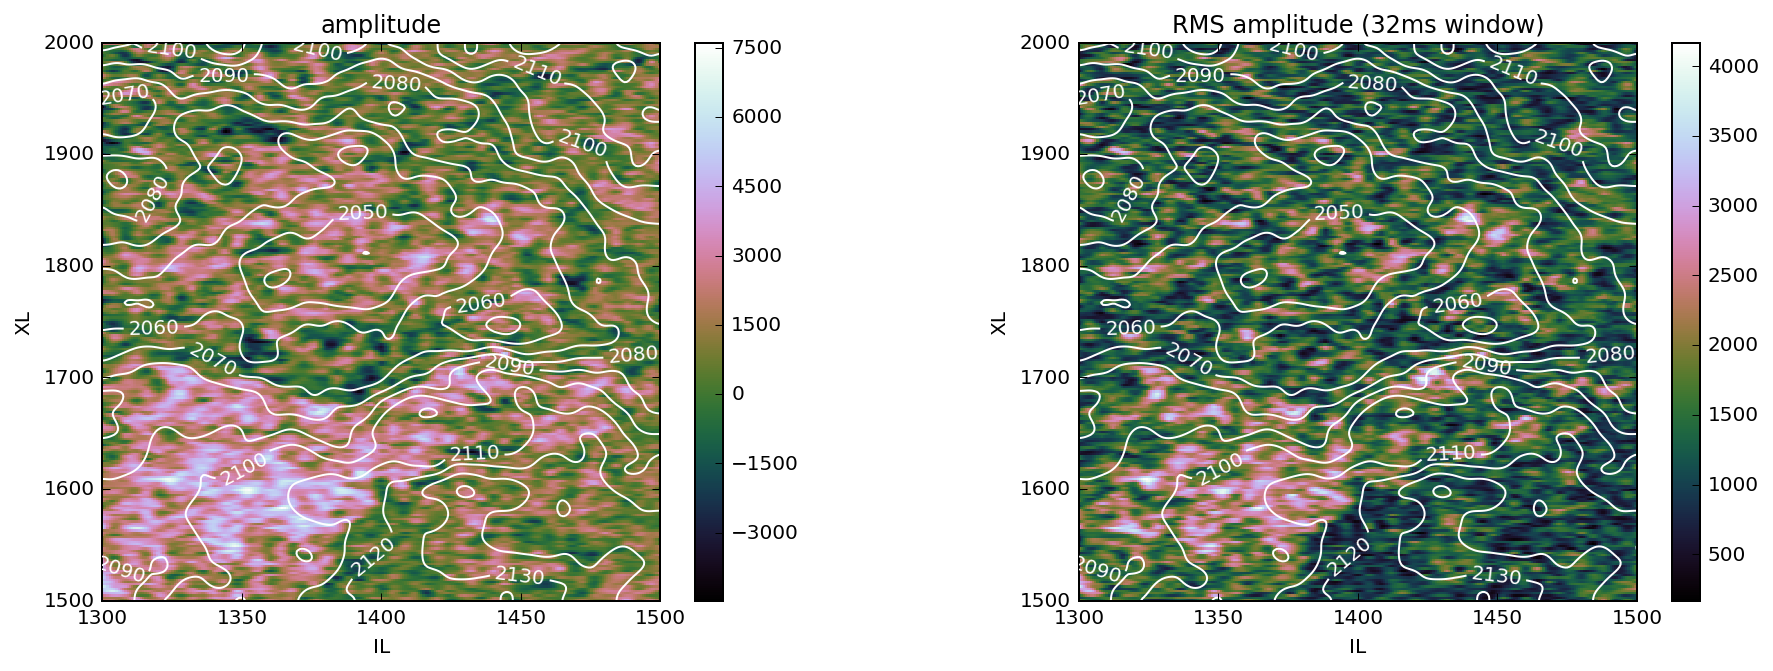

In [27]:
f, ax = plt.subplots(1,2,figsize=(15,5))
map0 = ax[0].pcolormesh(X, Y, Aspl, cmap='cubehelix')
map1 = ax[1].pcolormesh(X, Y, Arms, cmap='cubehelix')
plt.colorbar(map0, ax=ax[0])
plt.colorbar(map1, ax=ax[1])
ax[0].set_title('amplitude')
ax[1].set_title('RMS amplitude (32ms window)')
for aa in ax.flatten():
    aa.set_xlabel('IL'), aa.set_ylabel('XL')
    CS=aa.contour(X,Y,Zf,10,colors='w')
    plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
f.subplots_adjust(wspace=.4)

## further readings

* [Smoothing surfaces and attributes](http://library.seg.org/doi/abs/10.1190/tle33020128.1), by Matt Hall (article on The Leading Edge)
* [horizons and attributes](https://github.com/kwinkunks/notebooks/blob/master/Horizons_and_attributes.ipynb) by Matt Hall (the companion notebook to the above)
* [corendering attributes](https://github.com/agile-geoscience/notebooks/blob/master/Corendering_attributes.ipynb) and [corendering _more_ attributes](https://github.com/agile-geoscience/notebooks/blob/master/Corendering_more_attributes.ipynb) by Agile Geoscience (IPython/Jupyter notebooks)
* [Sobel filtering](https://github.com/kwinkunks/notebooks/blob/master/Sobel_filtering_horizons.ipynb) by Matt Hall (IPython notebook)